In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils

import pandas as pd
import numpy as np
import os
import pickle
from IPython.display import display, HTML
import finbox

In [2]:
country = 'USA'
prediction_location = os.path.join(os.getcwd(), 'cache')

with open(os.path.join(prediction_location, '%s_preds_t120_p12.pickle' % country), 'rb') as f:
    preds = pickle.load(f)

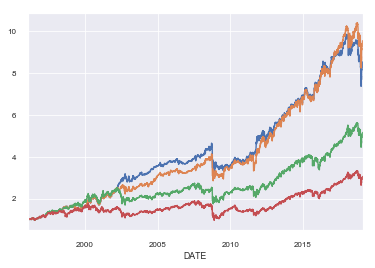

In [3]:
(preds['returns_0.0'] + 1).cumprod().plot()
(preds['returns_0.3'] + 1).cumprod().plot()
(preds['returns_0.5'] + 1).cumprod().plot()
(preds['returns_0.7'] + 1).cumprod().plot()

In [62]:
weights = utils.reverse_labels_to_weights(country, preds['preds'], 
                                          preds['probla'],
                                          preds['labels'],
                                          0.)

assets = utils.construct_virtual_assets(country)

In [63]:
# Backtest with finbox

strat = finbox.backtest.build_weights_rebalance_strategy(
    tickers=['QUA', 'HMLFF', 'SMB', 'UMD', 'MKT'],
    weights=weights,
    datasets=assets,
    lazy_rebalance=True,
    is_debug=False,
    commission_settings=[
        {'commission': 0.01, 'name': 'UMD'},
        {'commission': 0.0035, 'name': 'HMLFF'},
        {'commission': 0.0035, 'name': 'SMB'},
        {'commission': 0.005, 'name': 'QUA'},
        {'commission': 0.001, 'name': 'MKT'}
    ],  # applied 0.1% transaction costs for each trade
    weight_slippage=0.025
)

In [64]:
benchmark1 = preds['returns_mkt']
benchmark1.name = 'MKT'
benchmark1 = benchmark1[benchmark1.index >= weights.index[0]]

benchmark2 = preds['returns_equal']
benchmark2.name = 'Equal'
benchmark2 = benchmark2[benchmark2.index >= weights.index[0]]

,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.55,2002-10-09,2008-10-27,2013-05-15,2766
1,26.98,2017-12-28,2018-12-25,NaT,NaN
2,23.62,1998-08-31,2000-12-20,2001-04-03,677
3,14.75,2001-04-04,2001-10-01,2002-03-27,256
4,10.21,2015-03-02,2015-09-18,2016-03-17,274


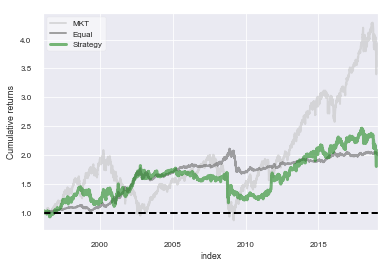

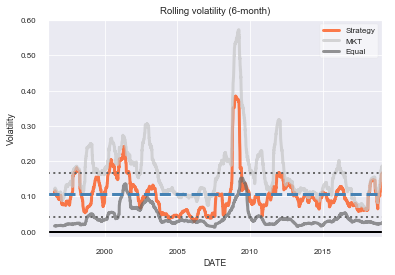

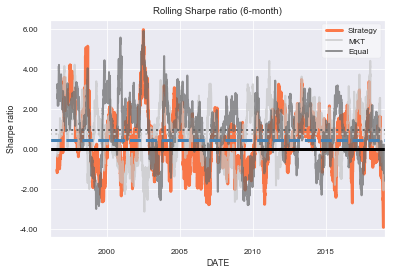

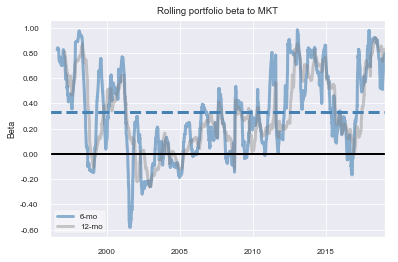

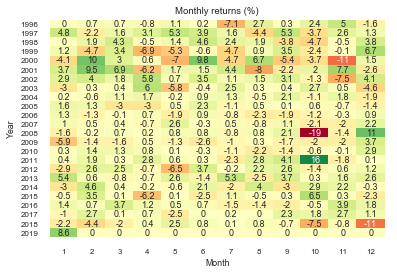

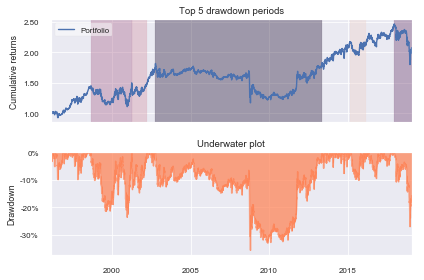

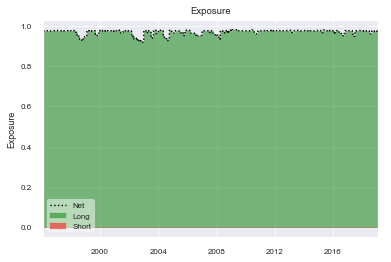

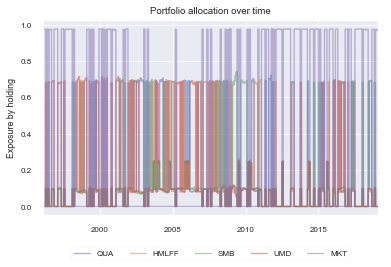

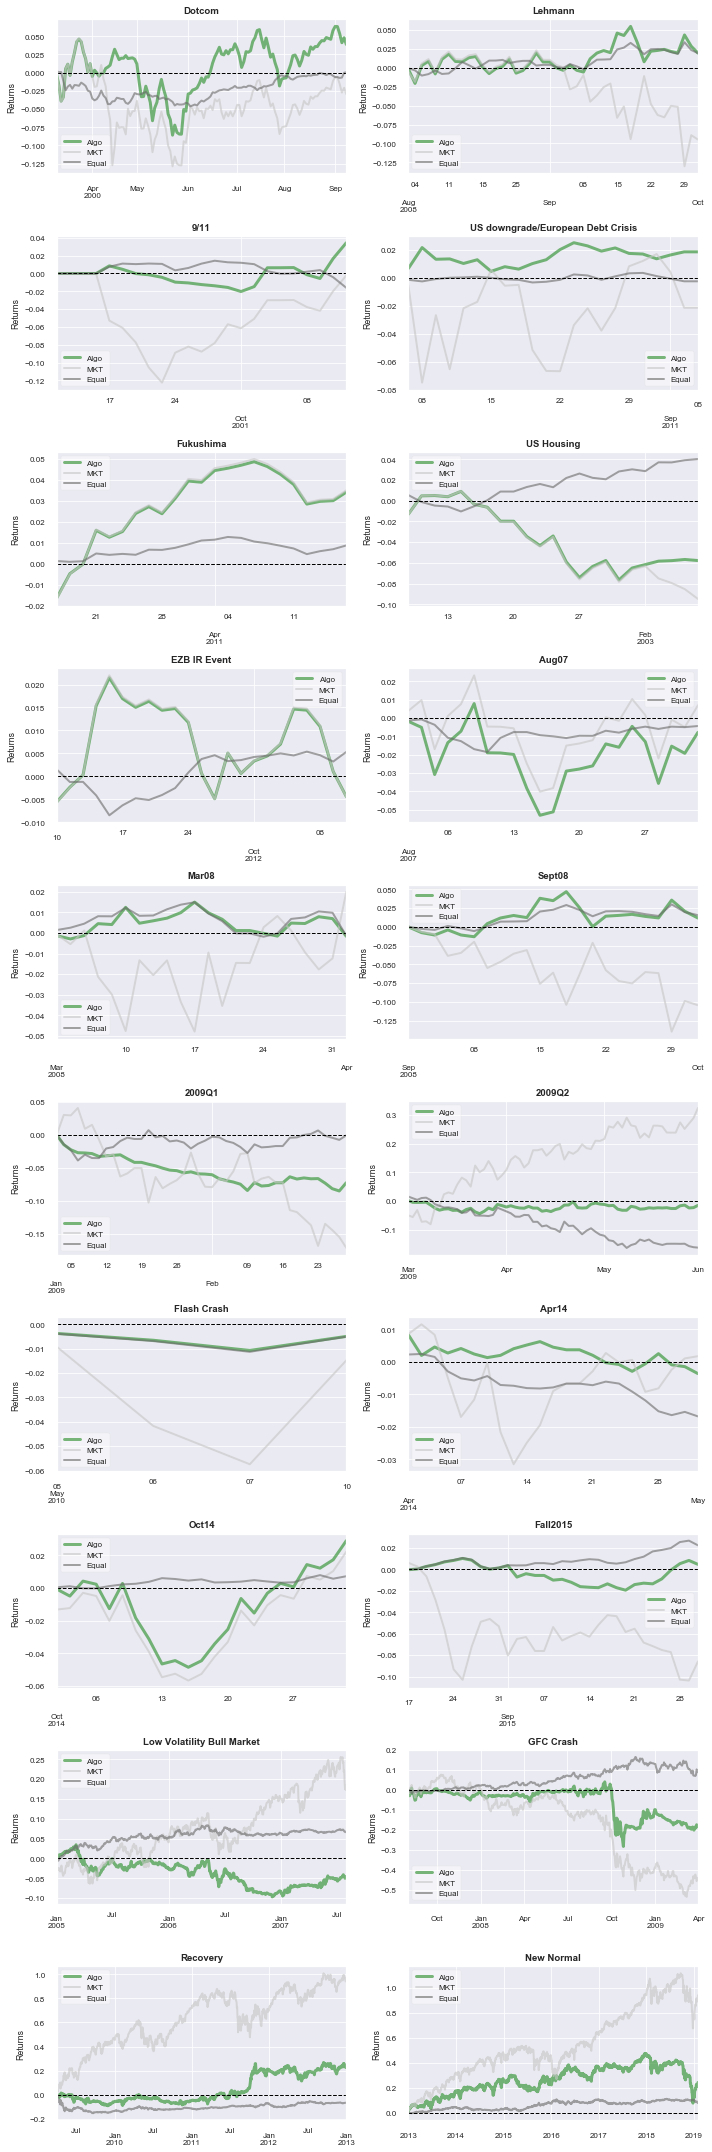

In [65]:
# Run Report Builder with matplotlib inside jupyter notebook
rb = finbox.backtest.report.ReportBuilder
rb = rb(strat, [benchmark1, benchmark2])

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rb.build_report(chart_type='matplotlib')

## Feature Importances

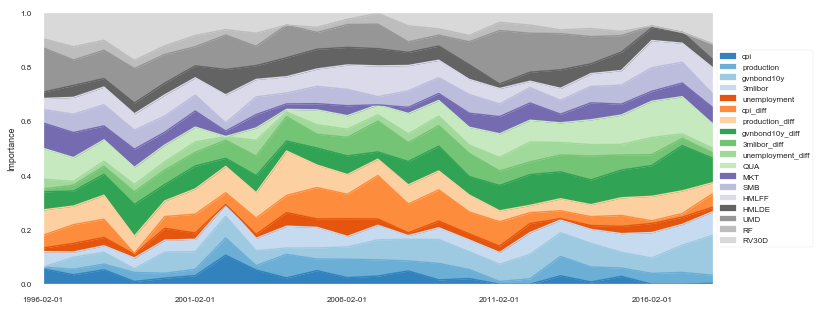

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12, 5))
utils.plot_feature_importance_over_time(preds['models'],
                                        utils.FeatureBuilder().get_features().columns.tolist(),
                                        ax)

## Weights Shifts

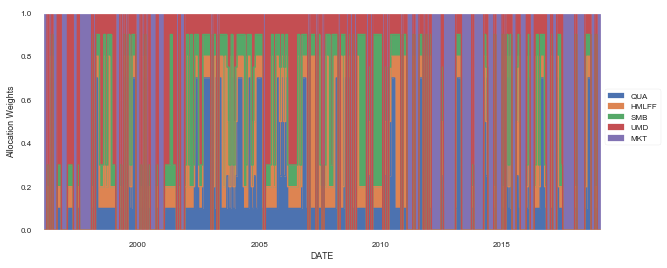

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10, 4))
weights.plot.area(ax=ax)
ax.set_ylim((0, 1))
ax.set_ylabel('Allocation Weights')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.52))

C:\Users\l5453\Anaconda3\envs\dam\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


Text(0, 0.5, 'Portfolio Value')

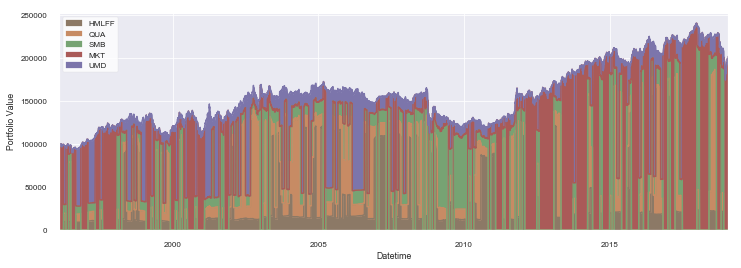

In [66]:
factors = ['HMLFF', 'QUA', 'SMB', 'MKT', 'UMD']
colors=[utils.COLOR_MAPPER[factor] for factor in factors]

ax = rb.positions[factors].plot.area(figsize=(12, 4), color=colors)
ax.set_ylabel('Portfolio Value')